# Task intro
We'll play with a dataset of diverse images of fruits and vegetables

**The task is to retrieve all the photos in a dataset that correspond
to a particular fruit/vegetable.**

In [1]:
from typing import Iterable

import numpy as np
import matplotlib.pyplot as plt

from transformers import CLIPProcessor, CLIPModel
from datasets import load_dataset

# Main input

In [37]:
# The food item to look for!
FOOD_NAME = "grapes"

# Load Dataset

In [38]:
DATASET_URL = "https://storage.googleapis.com/data-puzzles.appspot.com/fruits-test.zip"

In [39]:
# Notice we are only loading a test set here, no TRAIN split (= we'll use zero shot predictions)
ds = load_dataset(
    # can load remote data: https://huggingface.co/docs/datasets/image_load#imagefolder
    "imagefolder", 
    # If download takes too long through this method, download the ZIP file manually and replace with local path
    data_files=DATASET_URL,
    # split keyword to ignore. "train" is expected when calling the method with just one folder of files
    split="train" 
)


In [40]:
ds

Dataset({
    features: ['image'],
    num_rows: 1308
})

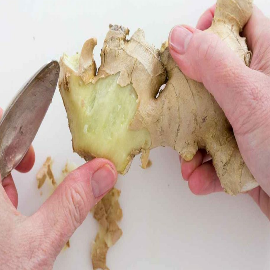

In [41]:
# This is a collection of images of fruits and vegetables
ds[0]["image"]

In [42]:
# Convert images to NP arrays
ds = ds.map(
    lambda element: {"image_data": np.asarray(element["image"])}
)

# Solution

## 1) Apply CLIP model over the dataset

In [43]:
# doc: https://huggingface.co/openai/clip-vit-base-patch32
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

model.eval()
model.to("cpu") # switch to GPU if you have one
print(f"Model loaded on {model.device}")

Model loaded on cpu


In [44]:
# To find the images of the food we're interested in, we'll compare
# the logits of the images with the query "a photo of a [FOOD_NAME]"
# hoping the full distribution of logits will yield something interesting.
# [Exercise] Can you suggest other ways to do the same?
def get_food_image_logits(food_name: str, images_batch: Iterable):
    # Scans all images in the batch via clip to match with the food name
    # and returns logits.
    inputs = processor(
        text=[f"a photo of {food_name}"],
        images=[np.asarray(im) for im in images_batch],
        return_tensors="pt",
        # Padding not needed, we're sending only one text item
    )
    
    outputs = model(**inputs)
    logits = outputs.logits_per_image # this is the image-text similarity score, in logits space

    return logits[:, 0]

In [45]:
# apply over dataset
ds = ds.map(
    lambda elements_batch: {
        f"{FOOD_NAME}_logit": get_food_image_logits(FOOD_NAME, elements_batch["image_data"])
    },
    batched=True,
    batch_size=128
)

Map:   0%|          | 0/1308 [00:00<?, ? examples/s]

## 2) Find relevant food images

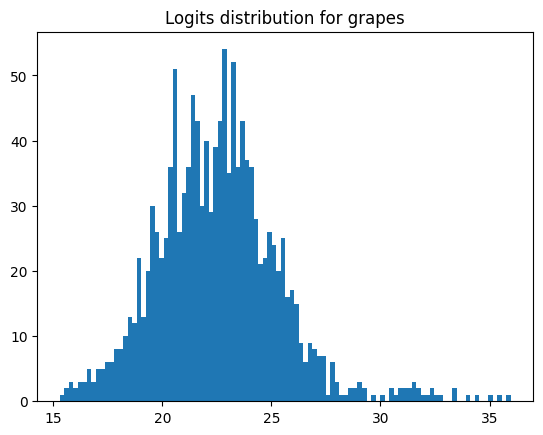

In [46]:
all_logits = ds[f"{FOOD_NAME}_logit"]

plt.title(f"Logits distribution for {FOOD_NAME}")
plt.hist(all_logits, bins=100)
plt.show()

In [49]:
# For 'grapes' there's a bell curve and a few outliers on the right
# that may come from another bell curve on the right
# let's display those

ranked_logit_indice_pairs = sorted(zip(all_logits, range(len(all_logits))), reverse=True)

N_DISPLAY = 40
top_indices = [ind for log, ind in ranked_logit_indice_pairs[:N_DISPLAY]]

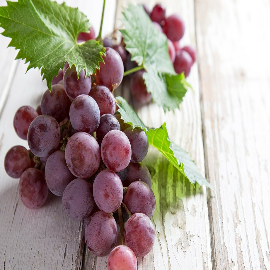

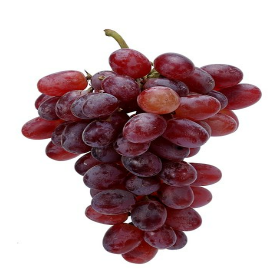

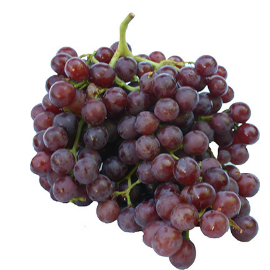

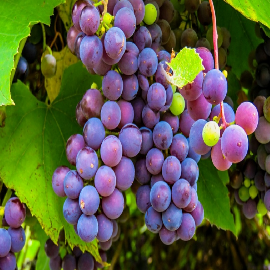

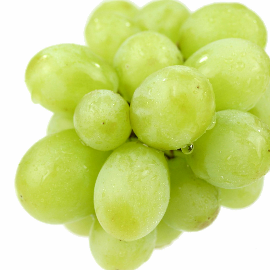

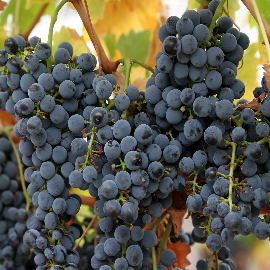

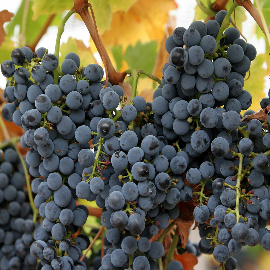

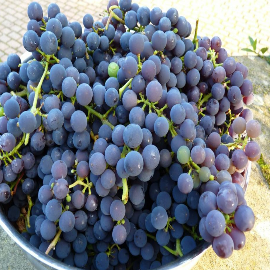

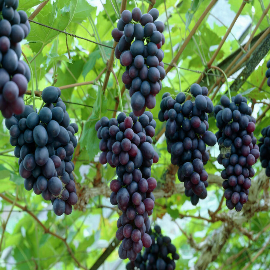

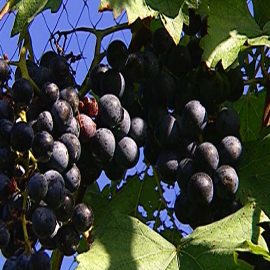

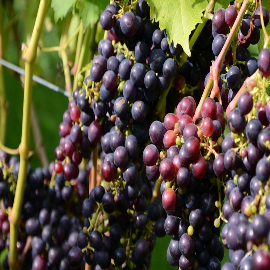

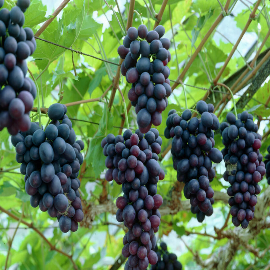

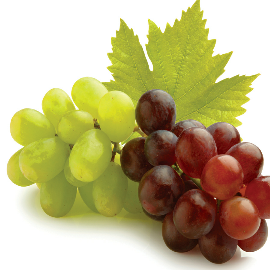

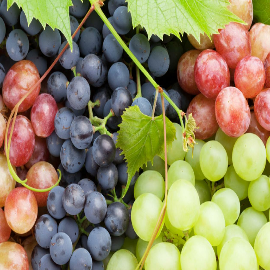

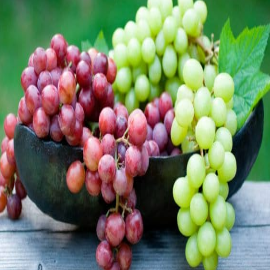

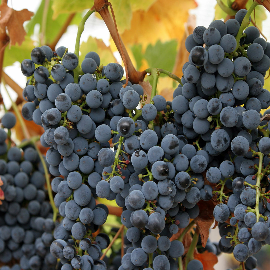

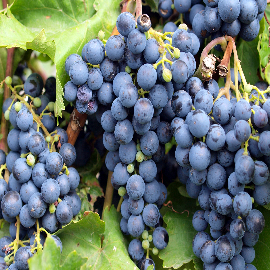

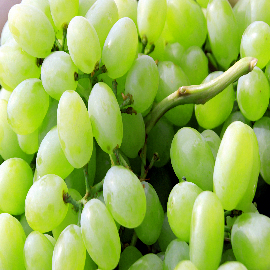

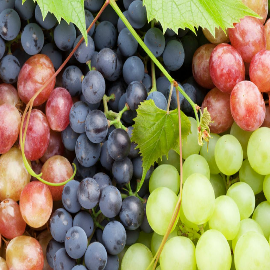

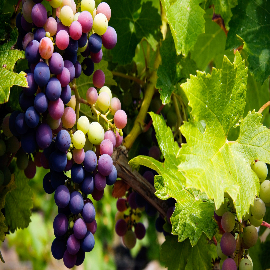

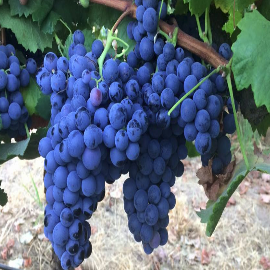

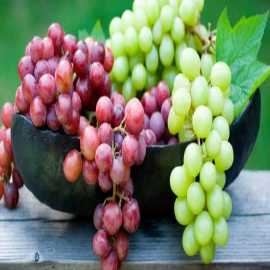

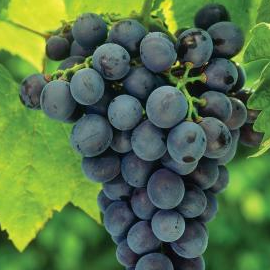

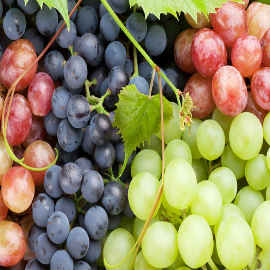

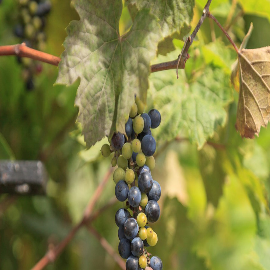

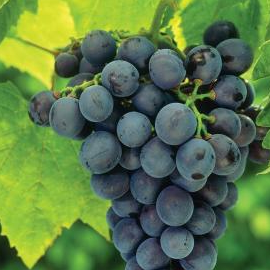

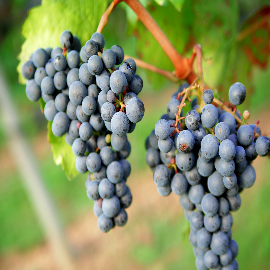

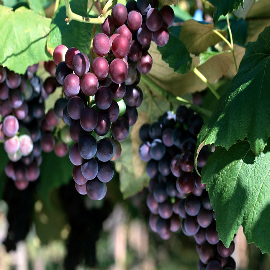

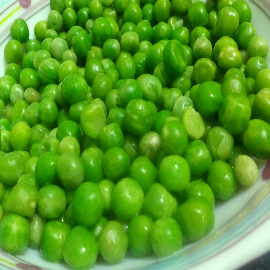

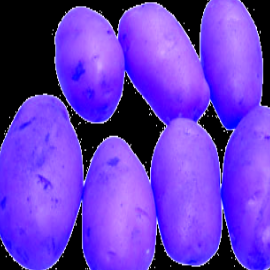

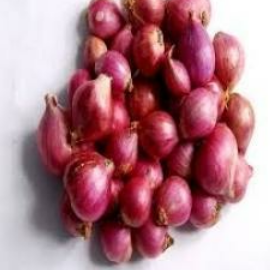

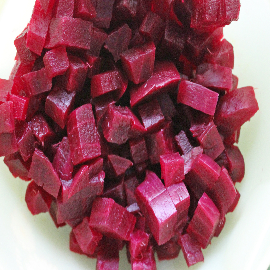

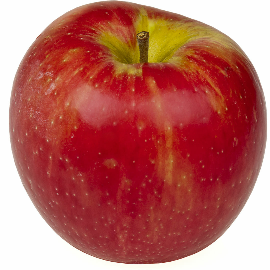

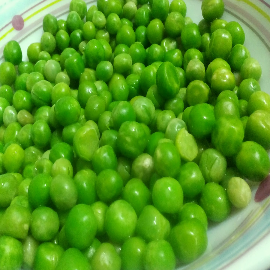

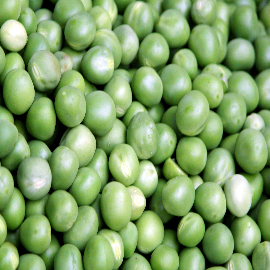

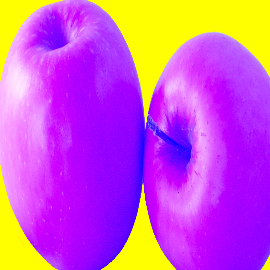

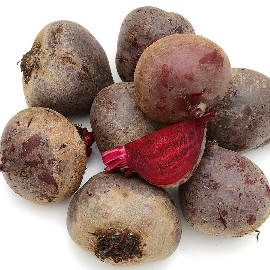

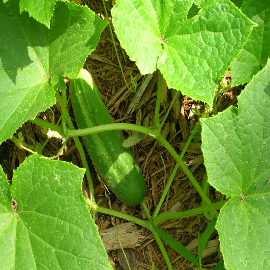

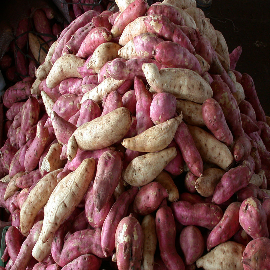

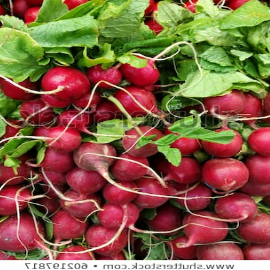

In [50]:
for ind in top_indices:
    display(ds[ind]["image"])

In [ ]:
# We can then manually find a relevant threshold and discard one or two errors.
# [Exercise] If we had 100 times more images this wouldnt be convenient, what would we do then?

# We might still be missing some relevant images in the dataset that would
# incorrectly have a low logit, we are putting quite a lot of trust in
# the model here!

# [Exercise] What can we do to say things like: "I'm confident I found at least X% of the relevant images!"

# [Follow-up] Imagine how you would have done the same in 2020 (CLIP not released yet)
# probably something like -> https://colab.research.google.com/drive/125iiEYwzEisa2LL2i6xRfqWDgHtCuB1k?usp=sharing#scrollTo=3vHtJOg5aPLa